<a href="https://colab.research.google.com/github/sensiboi/Route-Optimization-on-Zomato-Logistics/blob/main/Zomato_Logistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Zomato Logistics Route Optimization**

Importing Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Loading Datasets

In [9]:
df = pd.read_csv("Zomato Dataset.csv")

Display the basic info

In [10]:
print("Initial Data Shape:", df.shape)
print(df.columns)

Initial Data Shape: (45584, 20)
Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken (min)'],
      dtype='object')


Cleaning the data: Remove the missing value and duplicates

In [11]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

**Feature Engineering**

Create delivery distance (in km) using lat-long pairs

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [7]:
df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken (min)'],
      dtype='object')

In [13]:
df['distance_km'] = df.apply(lambda x: haversine(
    x['Restaurant_latitude'], x['Restaurant_longitude'],
    x['Delivery_location_latitude'], x['Delivery_location_longitude']
), axis=1)

Rename the target variable

In [14]:
df.rename(columns={'Time_taken (min)': 'time_taken_min'}, inplace=True)

Create a new column: Delivery efficiency= Distance/Time

In [15]:
df['delivery_efficiency'] = df['distance_km'] / df['time_taken_min']

**Analytical Capability Model (Regression)**

Setting target and features

In [16]:
features = ['Delivery_person_Ratings', 'Vehicle_condition', 'multiple_deliveries']
target = 'delivery_efficiency'

Scale and Split

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target]

Train and Test the model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluate the performance

In [20]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nModel Performance:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


Model Performance:
R² Score: 0.000
RMSE: 16.291


In [21]:
coeff_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print("\nRegression Coefficients:")
print(coeff_df)


Regression Coefficients:
                   Feature  Coefficient
0  Delivery_person_Ratings     0.071697
1        Vehicle_condition     0.091659
2      multiple_deliveries    -0.130526


Visualization of Feature Importance

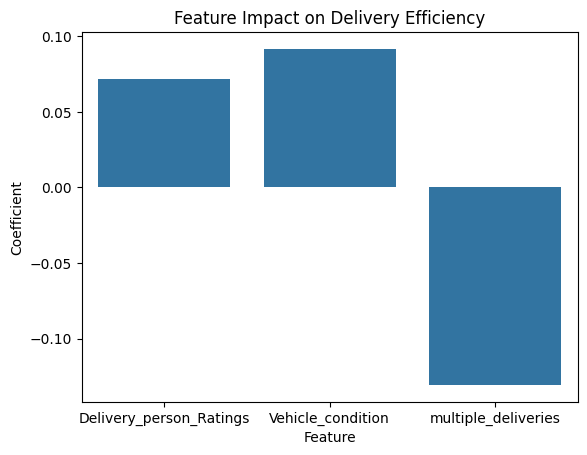

In [22]:
sns.barplot(x='Feature', y='Coefficient', data=coeff_df)
plt.title("Feature Impact on Delivery Efficiency")
plt.show()

**Route Optimization Simulation (Dark Store)**

Randomply Sample 1 Dark sore + 7 customer points from datasets

In [23]:
dark_store = df[['Restaurant_latitude', 'Restaurant_longitude']].iloc[0]
customers = df[['Delivery_location_latitude', 'Delivery_location_longitude']].sample(7, random_state=42)

locations = pd.DataFrame({
    'Name': ['Dark_Store'] + [f'Customer_{i}' for i in range(1, 8)],
    'Latitude': [dark_store['Restaurant_latitude']] + list(customers['Delivery_location_latitude']),
    'Longitude': [dark_store['Restaurant_longitude']] + list(customers['Delivery_location_longitude'])
})

Create the distance matrix

In [24]:
def distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
dist_matrix = pd.DataFrame(index=locations['Name'], columns=locations['Name'])
for i in locations.index:
    for j in locations.index:
        dist_matrix.iloc[i, j] = distance(
            locations.loc[i, 'Latitude'], locations.loc[i, 'Longitude'],
            locations.loc[j, 'Latitude'], locations.loc[j, 'Longitude']
        )

Nearest Neighbour Route Optimization

In [25]:
unvisited = list(dist_matrix.columns[1:])
route = ['Dark_Store']
current = 'Dark_Store'

while unvisited:
    next_stop = min(unvisited, key=lambda x: dist_matrix.loc[current, x])
    route.append(next_stop)
    unvisited.remove(next_stop)
    current = next_stop

print("\nOptimized Delivery Route:")
print(" ➜ ".join(route))



Optimized Delivery Route:
Dark_Store ➜ Customer_2 ➜ Customer_7 ➜ Customer_5 ➜ Customer_4 ➜ Customer_3 ➜ Customer_1 ➜ Customer_6


Visualization of Route

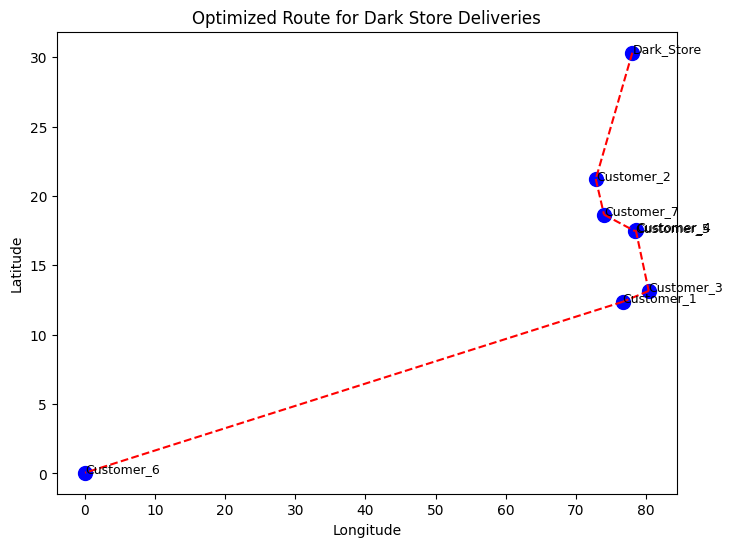

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(locations['Longitude'], locations['Latitude'], c='blue', s=100)
for i, row in locations.iterrows():
    plt.text(row['Longitude']+0.001, row['Latitude'], row['Name'], fontsize=9)
for i in range(len(route)-1):
    start = locations.loc[locations['Name']==route[i]]
    end = locations.loc[locations['Name']==route[i+1]]
    plt.plot([start['Longitude'].values[0], end['Longitude'].values[0]],
             [start['Latitude'].values[0], end['Latitude'].values[0]], 'r--')
plt.title("Optimized Route for Dark Store Deliveries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Summary table

In [27]:
summary = pd.DataFrame({
    "Metric": ["RMSE", "Best Route", "Top Influencer"],
    "Value": [round(rmse, 3), " ➜ ".join(route),
              coeff_df.loc[coeff_df['Coefficient'].idxmax(), 'Feature']]
})
print("\nSummary of Findings:")
print(summary)


Summary of Findings:
           Metric                                              Value
0            RMSE                                             16.291
1      Best Route  Dark_Store ➜ Customer_2 ➜ Customer_7 ➜ Custome...
2  Top Influencer                                  Vehicle_condition
